# Projet final  ( lgp @work )

## Sommaire <a class="anchor" id="Sommaire">
    
* [I - Acquisition et chargement des données](#I)
* [II - Analyse des données](#II)
* [III - Timeseries](#III)
* [IIV - Régression linéaire](#IV)
* [V - PCA](#V)
* [VI - Cartographie](#VI)
* [Conclusion et ouverture](#Conclusion)

## I - Acquisition et chargement des données <a class="anchor" id="I">

* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
* Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
* Extraction des caractéristiques techniques de chacun des voiliers.




In [1]:
# Chargement des libs
import pandas as pd
import os
import sys
from bs4 import BeautifulSoup as bs
import requests
import datetime as dt
import dateparser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# libs for xlsx "xxid" fix
import tempfile
from zipfile import ZipFile
import shutil
from fnmatch import fnmatch
import re
import glob
#

# variables utiliséees globalement
URL_RESULTS="https://www.vendeeglobe.org/fr/classement"
FILE_RESULTS="classement.html"
URL_GLOSSAIRE="https://www.vendeeglobe.org/fr/glossaire"
FILE_GLOSSAIRE="glossaire.html"
EXCELS_DIR="results"
PICKLE_DF="pickle_classement.pkl"
PICKLE_DF_TECH="pickle_classement_et_tech.pkl"
LABEL_FONT_SIZE=15

### Etape 1

* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.


In [2]:
def get_soup_from_url(url):
    """
    Retourne la soupe de l'url du fichier html passé en paramètre
    """
    res = requests.get(url)
    soup = bs(res.content, 'html.parser')
    return soup

def get_soup_from_file(file):
    """
    Retourne la soupe du fichier html passé en paramètre
    """
    soup = bs(file, 'html.parser')
    return soup

def parse_url_for_excels(url):
    """
    Récupère la liste des fichiers excel et les télécharge dans le répertoire "results/" (EXCELS_DIR)
    """
    print("Getting url of files to download...")
    soup = get_soup_from_url(url)
    dates_list = []
    for option in soup.find_all('option'):
        if option['value'] != '':
            dates_list.append(option['value'])
    
    # format de fichiers à récupérer 
    # https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210305_080000.xlsx
    print("Downloading xlsx files...")
    for date in dates_list:
        xlsx_name = f'vendeeglobe_{date}.xlsx'
        xlsx_file = requests.get(f"https://www.vendeeglobe.org//download-race-data/{xlsx_name}")
        open(os.path.join(EXCELS_DIR, xlsx_name), 'wb').write(xlsx_file.content)

def fix_xlsx_errors():
    """
    Fix des fichiers xlsx, un header xxid dans un des fichiers du xlsx n'est pas reconnu par openpyxl
    """
    print("Fixing xlsx files...")
    for file in [f for f in glob.glob(EXCELS_DIR + "/*.xlsx")]:
        change_in_zip(file, name_filter='xl/styles.xml', # the problematic property is found in the style xml files
                      change=lambda d: re.sub(b'xxid="\d*"', b"", d))
        
# fix of xlsx files
def change_in_zip(file_name, name_filter, change):
    """
    le fix appliqué à chaque fichier
    """
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)          
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)


def get_excel_files():
    if not os.path.isdir(EXCELS_DIR):
        os.mkdir('results')
        print("Files being downloaded to ", EXCELS_DIR)
        parse_url_for_excels(URL_RESULTS)
        fix_xlsx_errors()
    else:
        print(f"Les fichiers sont déjà dans le répertoire \"{EXCELS_DIR}/\" et déjà traités, aucun nouveau fichier n'a été téléchargé ni traité.")


**L'appel à la commande *get_excel_files.xlsx* ne fait rien si le répertoire *results/* existe déjà. Il est crée lors du 1er téléchargement des fichiers** 

In [3]:
%%time
get_excel_files()

Les fichiers sont déjà dans le répertoire "results/" et déjà traités, aucun nouveau fichier n'a été téléchargé ni traité.
CPU times: user 1.23 ms, sys: 101 µs, total: 1.33 ms
Wall time: 1.11 ms


### Etape 2 

* Chargement dans un dataframe (clean up et split des noms de colonne, préparation des data pour traitements)

In [4]:
def create_dataframe_from_files(path, verbose=True):
    """
    Sélection des fichiers et concatenate dans une dataframe
    
    Returns a dataframe
    """
    if not verbose:
        print("Quiet mode activated. Be patient...", end='')
    dfs=[]
    for filename in [f for f in glob.glob(path + "/*.xlsx")]:
        # on exclu les fichiers donnant des infos sur les concurrents arrivées (à partir du 27 janvier)
        # on exclu le 1er fichier au départ qui est sans données
        if filename >= path+'/vendeeglobe_20210127_170000.xlsx' or filename == path+"/vendeeglobe_20201108_120200.xlsx":
            continue
        if verbose:
            print('Including file ', filename)

        # read excel
        x = pd.read_excel(filename, 
                          dtype=object,
                          skiprows=[1, 2, 3], 
                          header=1, 
                          usecols=range(1,21), 
                          skipfooter=4)
        # do not use col 0
        # remove footer
        # rename 1  Classement
        # split 2 on \n rename Pays /  Voile
        # split 3 on \n ren Skipper /  Bateau
        # change names

        # ajout colonne avec le timestamp du fichier d'où est extrait la data
        date_str = filename[-20:-5]
        x['Fichier de resultats'] = date_str
        x['Timestamp'] = pd.to_datetime(date_str, format="%Y%m%d_%H%M%S")
        dfs.append(x)
    
    df = pd.concat(dfs , ignore_index=True)
    #df.duplicated().value_counts()

    if not verbose:
        print("done")
    return df

##############################################################
## Fonction qui convertit les coordonnées en format décimal ##
##############################################################

def dms2dec(deg, mn, sec):
    return deg + mn / 60 + sec / 3600

def clean_data(df, verbose=True):
    """
    Cleanup des noms de colonnes
    """
    print('Cleaning dataframe... ', end='')

    # cleanup sur nom dde cols, etc.
    df.rename(inplace=True, columns={'Unnamed: 1': 'Classement', 'Unnamed: 2': 'Pays', 'Unnamed: 3': 'Skipper', 
                                    'Unnamed: 19': 'DTF', 'Unnamed: 20': 'DTL', "Heure FR\nHour FR": "Heure FR"})
    df[['Pays','Voile']] = df["Pays"].str.extract("(.*)\n(.*)").astype(str)
    df[['Skipper','Bateau']] = df["Skipper"].str.extract("(.*)\n(.*)").astype(str)
    df[['Heure FR']] = df["Heure FR"].str.extract("(.*)\n.*").astype(str)
    df.rename(inplace=True, columns={'Latitude\nLatitude': 'Latitude', 
                    'Longitude\nLongitude': 'Longitude', 
                    'Cap\nHeading': 'Cap 30m', 'Vitesse\nSpeed': 'Vitesse 30m', 
                    'VMG\nVMG': 'VMG 30m', 'Distance\nDistance': 'Distance 30m',
                    'Cap\nHeading.1': 'Cap dernier', 'Vitesse\nSpeed.1': 'Vitesse dernier', 
                    'VMG\nVMG.1': 'VMG dernier', 'Distance\nDistance.1': 'Distance dernier',
                    'Cap\nHeading.2': 'Cap 24h', 'Vitesse\nSpeed.2': 'Vitesse 24h', 
                    'VMG\nVMG.2': 'VMG 24h', 'Distance\nDistance.2': 'Distance 24h'})

    for col in ['Vitesse 30m','VMG 30m', 'Vitesse dernier', 'VMG dernier', 'Vitesse 24h', 'VMG 24h']:
        df[[col]] = df[col].str.extract("(.*) kts").astype(float)
    for col in ['Distance 30m', 'Distance dernier', 'Distance 24h', 'DTF', 'DTL']:
        df[[col]] = df[col].str.extract("(.*) nm").astype(float)
    for col in ['Cap 30m', 'Cap dernier', 'Cap 24h']:
        df[[col]] = df[col].str.extract("(\d*)°").astype(float)

    # classement des abandons trasnformé en int
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('RET', '34')).astype(str)
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('NL', '35')).astype(str)
    
    # VMG : Velocity Made Good = projection du vecteur vitesse sur la route théorique. Ou plus simplement : vitesse de rapprochement au but.
    # DTF : Distance To Finish = Distance théorique la plus courte pour rejoindre l'arrivée; DTL : Distance To Leader = différence de distance au but avec le premier au classement

    # suppression des lignes avec Nan
    # ce sont les abandons
    df = df.dropna()

    A = df['Longitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    A['D'] = df['Longitude'].str.extract(".*'(.)").astype(str)
    df['Longitude_dec'] = dms2dec(A[0],A[1],A[2])
    df['Longitude_dec'] = np.where(A['D'] == 'W', -df['Longitude_dec'], df['Longitude_dec'])

    B = df['Latitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    B['D'] = df['Latitude'].str.extract(".*'(.)").astype(str)
    df['Latitude_dec'] = dms2dec(B[0],B[1],B[2])
    df['Latitude_dec'] = np.where(B['D'] == 'S', -df['Latitude_dec'], df['Latitude_dec'])
   

    print("done")
    return df

In [5]:
%time
# backup dans un fichier pickle pour ne pas retraiter à chaque run
if not os.path.isfile(PICKLE_DF):
    print(f"\nLoading data from {EXCELS_DIR}/*.xlsx files")
    df = create_dataframe_from_files(EXCELS_DIR, verbose=False)
    df = clean_data(df)
    df.to_pickle(PICKLE_DF)
    print(f"{PICKLE_DF} saved")
else:
    print(f"\nLoading data from pickle file {PICKLE_DF}...", end='')
    df = pd.read_pickle(PICKLE_DF)
    print(' done')
    print(f'\n(Note: if you need to reset pickle content remove file {PICKLE_DF} manually)')
    
df.shape

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs

Loading data from pickle file pickle_classement.pkl... done

(Note: if you need to reset pickle content remove file pickle_classement.pkl manually)


(13703, 26)

In [6]:
df.iloc[10000]

Classement                                     29
Pays                                             
Skipper                            Clément Giraud
Heure FR                                 12:30 FR
Latitude                               38°56.43'N
Longitude                              19°07.68'W
Cap 30m                                     228.0
Vitesse 30m                                   4.2
VMG 30m                                       3.3
Distance 30m                                  2.1
Cap dernier                                 177.0
Vitesse dernier                               3.8
VMG dernier                                   3.7
Distance dernier                             11.4
Cap 24h                                     241.0
Vitesse 24h                                   8.2
VMG 24h                                       5.7
Distance 24h                                196.7
DTF                                       23557.6
DTL                                         370.4


### Etape 3 - infos techniques

* Ajout des informations sur la présence de foils et du classement final depuis la page classement
* Extraction des caractéristiques techniques de chacun des voiliers depuis la page glossaire



In [7]:
def get_infos_from_classement(df):
    """
    Récupère les infos skipper, foil, etc.
    
    Retourne une liste de liste de [classement final, nom skipper, Oui/Non (foil)]
    """
    print("Getting boats infos...")
    classement_html=""
    if not os.path.isfile(FILE_RESULTS):
        print("Reading file from far away")
        req = requests.get(URL_RESULTS)
        classement_html = req.content
        open(os.path.join(FILE_RESULTS), 'wb').write(classement_html)
    else:
        print("Reading file locally")
        with open(FILE_RESULTS,'r') as file:
            classement_html = file.read()

    soup = get_soup_from_file(classement_html)
    skippers_info=[]
    for ranking_row in soup.find_all("tr", {"class": "ranking-row"}):
        cell_rank = ranking_row.find('td', attrs={'class': 'row-number'} ).text
        cell_skipper = ranking_row.find('td', attrs={'class': 'row-skipper'} ).contents[2]
        cell_skipper = re.search(r'\n\s+(\w[\s\'\w-]*)', cell_skipper).group(1).title()
        cell_has_foil = ranking_row.find('td', attrs={'class': 'row-layout'} ).text
        skippers_info.append([cell_rank, cell_skipper, cell_has_foil])
    return skippers_info

# Extraction des caractéristiques techniques de chacun des voiliers.
def get_infos_from_glossaire():
    """
    Récupère les infos skipper, foil, etc.
    """
    if not os.path.isfile(FILE_GLOSSAIRE):
        print("Reading file from far away..." , end='')
        req = requests.get(URL_GLOSSAIRE)
        glossaire_html = req.content
        open(os.path.join(FILE_GLOSSAIRE), 'wb').write(glossaire_html.content)
    else:
        print("Reading file locally... " , end='')
        with open(FILE_GLOSSAIRE,'r') as file:
            glossaire_html = file.read()

    soup = get_soup_from_file(glossaire_html)
    
    tech_info={}
    
    boats_popup_infos = soup.find_all('div', attrs={'class': 'boats-list__popup-infos'})
    specs_list = soup.find_all('ul', attrs={'class': 'boats-list__popup-specs-list'})
#     print(len(boats_popup_infos), len(specs_list))
#     v = []
    for i in range(len(boats_popup_infos)):
        bateau = boats_popup_infos[i].h3.text
        specs = specs_list[i]
        voile = specs.find(string=re.compile("Numéro de voile : "))
        if voile == None:
            voile = 0
        else:
            voile = re.match(".*: ([\w\s]+)", voile)[1]
        anc_name = specs.find(string=re.compile("Anciens noms du bateau : "))
        if anc_name==None:
            anc_name = bateau
        else:    
            anc_name = re.match(".*: ([,\w\s]+)", anc_name)[1]
        Architecte = specs.find(string=re.compile("Architecte")) # : Marc Lombard</li>
        Architecte = re.match(".*: ([\s\w]+)", Architecte)[1]
        Chantier= specs.find(string=re.compile("Chantier")) #MAG France</li>
        Chantier= re.match(".*: ([\s\w]+)", Chantier)[1]
        lancement= specs.find(string=re.compile("Date de lancement")) # : 01 Mars 1998</li>
        lancement= re.match(".*: ([\s\w]+)", lancement)[1]
        Longueur= specs.find(string=re.compile("Longueur")) # : 18,28m</li>
        Longueur= re.match(".*: ([,.\d]+)", Longueur)[1]
        Largeur = specs.find(string=re.compile("Largeur")) # : 5,54m</li>
        Largeur = re.match(".*: ([,\d]+)", Largeur)[1]
        Tirant = specs.find(string=re.compile("Tirant d'eau")) # : 4,50m</li>
        Tirant = re.match(".*: ([,\d]+)", Tirant)[1]
        poids = specs.find(string=re.compile("Déplacement")) # : 9t</li>
        poids = re.match(".*: ([,\dncNC]+)\s?t?", poids)[1]
        if poids=="nc" or poids=="NC":
            poids="0"
        derives = specs.find(string=re.compile("Nombre de dérives")) # : 2</li>
        derives = re.match(".*: (.*)", derives)[1]
        mat = specs.find(string=re.compile("Hauteur mât")) # : 29 m</li>
        mat = re.match(".*: ([,\d]+)", mat)[1]
        quille = specs.find(string=re.compile("Voile quille")) # : acier</li>
        if quille == None:
            quille = "NC"
        else:
            quille = re.match(".*: ([\s\w]+)", quille)[1].lower() 
        Surface_pres = specs.find(string=re.compile("Surface de voiles au près")) # : 260 m2</li>
        Surface_pres = re.match(".*: ([,\d]+).*m[2²]", Surface_pres)[1]
        Surface_portant = specs.find(string=re.compile("Surface de voiles au portant")) # : 580 m2</li>
        Surface_portant = re.match(".*: ([,\d]+).*m[2²]", Surface_portant)[1]

        # manual cleanup des numéros de voiles qui ne matchent pas avec les fichiers classements
        if bateau == 'LinkedOut':
            voile = "FRA 59"
        if voile == "001":
            voile = "FRA 01"
        if voile == "4":
            voile = "FRA 4" 
        if voile == "2":
            voile = "FRA 02"
#         if voile == "6":
#                 voile = "FRA 6"
        if voile == "08":
            voile = "FRA 8"
        if voile == "16":
            voile = "MON 10"
        if voile == "17":
            voile = "FRA 17"
        if voile == "18":
            voile = "FRA 18"
        if voile == "69":
            voile = "FRA 69"
        if voile == "SUI07":
            voile = "SUI 7"
        if voile == "GBR77":
            voile = "GBR 777"
        if voile[3] != " ":
#             print(voile)
            voile = voile[0:3]+" "+voile[3:]
#             print(voile)
        tech_info[voile] = {'Voile': voile, 'Nom bateau': bateau, 'Longueur': Longueur, 
                            'Largeur': Largeur, 'Tirant': Tirant, 
                           'Poids': poids, "Dérives": derives,
                           'Hauteur mât': mat, "Quille": quille, 
                            "Surface près": Surface_pres,  "Surface portant": Surface_portant,
                           "Année lancement": lancement[-4:], 'Ancien nom': anc_name}
#         v.append(voile)
    print("Done")
    return tech_info



Traitement manuel de la page web https://www.vendeeglobe.org/fr/classement pour récupérer l'info sur les foils et le classement final

Ajout des informations directement dans le dataframe 'df'

In [8]:

foils_etc = get_infos_from_classement(df)

# manual fixes
# skippers with names not matching
# from web page 2 errors
skips=set()
for f in foils_etc:
    skipper=f[1]
    skips.add(skipper)
all_skips = set(df['Skipper'])
# print(skips.difference(set(all_skips)))
df[['Skipper']] = df[['Skipper']].applymap(lambda x: x.replace('Arnaud Boissieres', 'Arnaud Boissières')).astype(str)

for f in foils_etc:
    if f[1]=="Sam Davies":
        skipper = "Samantha Davies"
    elif f[1]=="Alan  Roura":
        skipper="Alan Roura"
    else:
        skipper=f[1]
    foil=f[2]
    
    df.loc[df['Skipper']==skipper, 'Foil'] = foil
    df.loc[df['Skipper']==skipper, 'Classement final'] = f[0]

df[['Classement final']] = df[['Classement final']].applymap(lambda x: x.replace('ABD', '34')).astype(str)
df[['Classement final']] = df[['Classement final']].astype(int)
df[['Classement']] = df[['Classement']].astype(int)


# set(df['Skipper'])
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Oui', '1')).astype(str)
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Non', '0')).astype(str)
df[['Foil']] = df[['Foil']].astype(int)
# df[['Foil']] = df[['Foil']].astype(bool)



Getting boats infos...
Reading file locally


* Ajout des informations techniques depuis la page glossaire

* Création d'un autre dataframe et merge avec le dataframe principal sur la clé "Voile" (par ex FRA 123)
* Nettoyage final des données


In [9]:

# tech_info contains a dict of technical details
# backup dans un fichier pickle pour ne pas retraiter à chaque run
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra


mapping_quilles={}
mapping_derives={}
mapping_inv_quilles={}
mapping_inv_derives={}
def last_cleanup(df):
    ## cleanup columns types, changing categorical values to numbers, renaming and ordering

    df['Tirant'] = df["Tirant"].str.replace(',','.').astype(float)
    df['Longueur'] = df["Longueur"].str.replace(',','.').astype(float)
    df['Largeur'] = df["Largeur"].str.replace(',','.').astype(float)
    df['Poids'] = df["Poids"].str.replace(',','.').astype(float)
    df["Hauteur mât"] = df["Hauteur mât"].str.replace(',','.').astype(float)
    df["Surface près"] = df["Surface près"].str.replace(',','.').astype(float)
    df["Surface portant"] = df["Surface portant"].str.replace(',','.').astype(float)
    df["Année lancement"] = df["Année lancement"].astype(int)


    for i, name in enumerate(sorted(df['Quille'].unique())):
        mapping_quilles[i]=name
        mapping_inv_quilles[name]=i
    for i, name in enumerate(sorted(df['Dérives'].unique())):
        mapping_derives[i]=name
        mapping_inv_derives[name]=i

    # traitement du gender
    df['Dérives'] = df['Dérives'].map(mapping_inv_derives)
    df['Quille']  = df['Quille'].map(mapping_inv_quilles)
    df['Dérives'] = df['Dérives'].astype(int)
    df['Quille']  = df['Quille'].astype(int)

    columns=['Timestamp', 'Classement', 'Classement final', 'Skipper', 'Bateau', 'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude',
           'Cap 30m', 'Vitesse 30m', 'VMG 30m', 'Distance 30m', 'Cap dernier',
           'Vitesse dernier', 'VMG dernier', 'Distance dernier', 'Cap 24h',
           'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL',
             'Latitude', 'Longitude', 'Latitude_dec', 'Longitude_dec',
           'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longueur', 'Largeur', 'Poids', 
           'Hauteur mât', 'Quille', 'Surface près', 'Surface portant',
           'Année lancement', 'Ancien nom']

    df = df[columns]
    return(df)

def merge(df):
    if not os.path.isfile(PICKLE_DF_TECH):  
        print(f"\nLoading boats technical data")
        tech_info = get_infos_from_glossaire()

        print(f"\nMerging df with technical data")
        df_tech_info = pd.DataFrame(tech_info).T        
        df_merge = pd.merge(df, df_tech_info, on="Voile")
        df_merge = last_cleanup(df_merge)
        df = df.reset_index()
        df = df.set_index('Timestamp').sort_index()
        
        df_merge.to_pickle(PICKLE_DF_TECH)
        print(f"Pickle file {PICKLE_DF_TECH} saved.")
    else:
        print(f"\nLoading data from pickle file {PICKLE_DF_TECH}...", end='')
        df_merge = pd.read_pickle(PICKLE_DF_TECH)
        df_merge = df_merge.set_index('Timestamp').sort_index()

        print(' done')
        print(f'\n(Note: if you need to renew pickle content remove file {PICKLE_DF_TECH} manually)')
    return df_merge

df = merge(df)
df = df.reset_index()
df = df.set_index('Timestamp').sort_index()
        
mapping_derives, mapping_quilles



Loading data from pickle file pickle_classement_et_tech.pkl... done

(Note: if you need to renew pickle content remove file pickle_classement_et_tech.pkl manually)


({}, {})

### Description des données présentes dans le dataframe

Nous avons maintenant un dataframe complet avec toutes nos données.

#### Fichiers inclus/exclus

J'ai pris l'option proposée de ne pas intégrer les fichiers vers la fin de la course. Les fichiers après le 20210127_170000 ne sont pas intégrés au dataframe, ni le premier qui ne contenait aucune données.

#### Classement général et classement final

Concernant les classements il y a 25 positions à l'arrivée (variable 'Classement final') sur 33 concurrents au départ. Les 33 positions apparaissent dans la variable 'Classement'

La position 34 (dans le 'Classement final') représente les abandons et apparaît dans certains graphes.

#### Mapping  quilles et dérives (foils)

Nous avons crée 2 mappings de données catégorielles pour les dérives et les quilles. Nous avons aussi une colonne 'Foil' qui distingue simplement la présence (1) ou l'absence de foil (0) sans distinction de type de dérive.

Les quilles et dérives en fonction des matériaux sont regroupés comme ci-après:

<pre>
Mapping des dérives :
0: '2'
1: '2 asymétriques'
2: 'foiler'
3: 'foils'

Mapping des quilles:
0: 'NC'
1: 'acier'
2: 'acier forgé'
3: 'acier mécano soudé'
4: 'basculante avec vérin'
5: 'basculante sur vérin hydraulique'
6: 'carbone'
7: 'inox usiné'
8: 'monotype'
</pre>

#### Coordonnées 

La coordonnées sont converties au format décimal et disponibles dans les 2 formats. 

#### Fichier de resultats

Le fichier d'où est extrait la donnée apparait sous forme de pattern DATE_HEURE dans le colonne 'Fichier de resultats'

#### Synthèse 

Nous montrons ci-dessous un exemple d'enregistrement et les informations DTypes.

**Contrôle d'une donnée et des Dtypes**

In [10]:
df.iloc[2546]

Classement                             8
Classement final                       1
Skipper                 Yannick Bestaven
Bateau                     Maître Coq IV
Voile                             FRA 17
Pays                                    
Heure FR                        11:30 FR
Latitude                      15°13.62'S
Longitude                     30°48.54'W
Cap 30m                            171.0
Vitesse 30m                         18.1
VMG 30m                             17.1
Distance 30m                         9.1
Cap dernier                        175.0
Vitesse dernier                     19.9
VMG dernier                         18.4
Distance dernier                    59.7
Cap 24h                            177.0
Vitesse 24h                         18.6
VMG 24h                             17.8
Distance 24h                       447.4
DTF                              20465.7
DTL                                392.3
Latitude                      15°13.62'S
Longitude       

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13703 entries, 2020-11-08 14:00:00 to 2021-01-27 14:00:00
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Classement            13703 non-null  int64  
 1   Classement final      13703 non-null  int64  
 2   Skipper               13703 non-null  object 
 3   Bateau                13703 non-null  object 
 4   Voile                 13703 non-null  object 
 5   Pays                  13703 non-null  object 
 6   Heure FR              13703 non-null  object 
 7   Latitude              13703 non-null  object 
 8   Longitude             13703 non-null  object 
 9   Cap 30m               13703 non-null  float64
 10  Vitesse 30m           13703 non-null  float64
 11  VMG 30m               13703 non-null  float64
 12  Distance 30m          13703 non-null  float64
 13  Cap dernier           13703 non-null  float64
 14  Vitesse dernier       13703 non-nul

([Retour Sommaire](#Sommaire))

## II- Analyse des données <a class="anchor" id="II">

* Rapprochement des données des voiliers avec celle des classements.
* Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
* Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
* Visualisation de la distance parcourue par voilier.
* Cartes avec les routes d'un ou plusieurs voiliers.
* Analyses de séries temporelles.
* Application d'algorithmes statistiques ou de machine learning.
* etc.

In [12]:
### la liste des skippers dans l'ordre d'arrivée
def get_skippers_ordered(df):
    skippers=df.loc[df['Classement final'].isin(range(1,25)), "Skipper"].unique().tolist()

    skippers=[]
    for k in range(1, 26):  # juste un for :-(
        skip = df.loc[df['Classement final']==k, 'Skipper' ].unique().tolist()
        skippers.append(skip[0])
    return skippers

#### Repérage sur les données et mise en évidence de quelques caractéristiques facilement observables

On affiche plusieurs pairplot pour visualiser des indices de causalité ou des corrélations

In [13]:
nom_colonne_y = "Classement final"

def show_graphs(num_df, nom_colonne_y):
    Y = num_df[nom_colonne_y]
    X_cols=[]
    X_cols = num_df.columns.to_list()
    # on enlève le nom de la colonne Y
    X_cols.remove(nom_colonne_y)

    X = num_df[X_cols]

    ncols=3
    nrows=int((len(num_df.columns)-1)/ncols)+ min(1, (len(num_df.columns)-1)%ncols)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(25 , 25))

    

    for i, ax ,col in zip(range(len(num_df.columns)-1), axes.flat, X_cols):
        ax.scatter(Y, X[col])
        ax.set_title(col + "/"+nom_colonne_y , fontsize = 16)
        ax.set_xlabel(nom_colonne_y, fontsize = 16)
        ax.set_ylabel(col, fontsize = 16)
    #     sns.distplot(data[i,0,0,0], hist=False, ax=ax)
    fig.tight_layout()
    plt.show()
    
    
def show_one_graph(num_df, nom_colonne_y, nom_colonne_x):
    Y = num_df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = num_df[X_cols]

    ax = plt.subplot(111)
    ax.scatter(Y, X)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()
    


In [14]:

def show_one_graph(df, nom_colonne_x, nom_colonne_y):
    Y = df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = df[X_cols]

    ax = plt.subplot(111)
    ax.scatter(Y, X)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()

On note que les foils sont présents ces dernières années

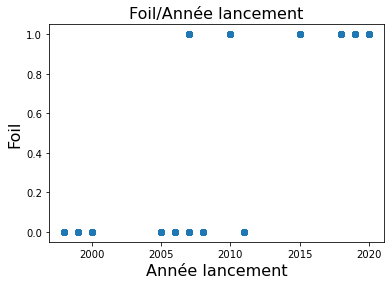

In [15]:
show_one_graph(df, "Foil", "Année lancement")

La surface de près pourrait avoir une influence. Piste pour une régression linéaire.

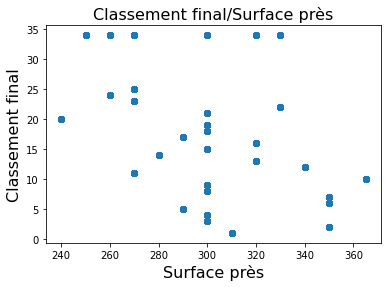

In [16]:
show_one_graph(df,  "Classement final", "Surface près")

Au même titre que le poids et les type de quille ont évolué. 

Les bateaux plus légers gagne mieux. 




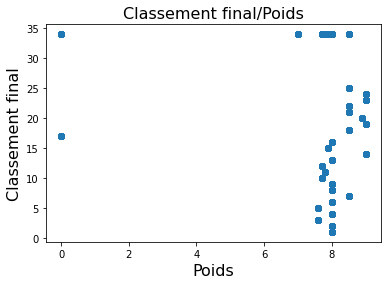

In [17]:
show_one_graph(df,  "Classement final", "Poids")

De même que certains types de quilles en acier et acier forgé.

<pre>
Mapping des quilles:
0: 'NC'
1: 'acier'
2: 'acier forgé'
3: 'acier mécano soudé'
4: 'basculante avec vérin'
5: 'basculante sur vérin hydraulique'
6: 'carbone'
7: 'inox usiné'
8: 'monotype'
</pre>

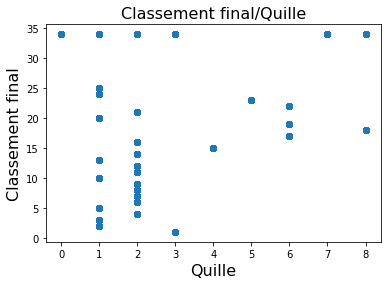

In [18]:
show_one_graph(df,  "Classement final", "Quille")

## II-A- Analyse de l'influence de la présence d'un foil 

On va observer que le foil présente des avantages et des inconvénients quant à l'effet sur le classement. 

Les foils sont un équipement assez récent (voir [graphe](#bateau-annee))
Sur bateuax élgers


#### Présence d'un foil et classement à l 'arrivée

Tout d'abord nous analysons le classement à l'arrivée des bateaux avec et sans foil.

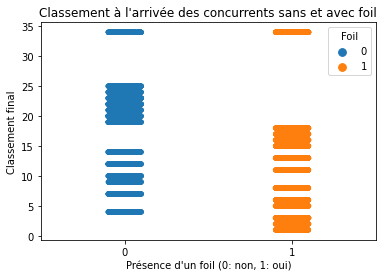

In [19]:
sns.stripplot(data=df, y='Classement final', x='Foil', hue='Foil')
plt.title("Classement à l'arrivée des concurrents sans et avec foil");
plt.xticks([0, 1]) # change xticks labels
plt.xlabel("Présence d'un foil (0: non, 1: oui)")
plt.yticks([1, 5, 10, 15, 20, 25, 34].reverse());

On observe dans le graphe ci-dessus que les bateaux avec foil semblent présenter un avantage. L'ensemble des 12 concurrents disposant de foils arrivent parmis les 17 premiers, laissant 7 concurrents sans foil derrière eux. Les 3 premiers sont équipés de foils. Ce qui pourrait laisser croire à un net avantage des bateaux avec foils.

Il faut toutefois noter que le nom d'abandons des bateaux avec foil est très élevés (7 contre 1 pour les bateaux "classiques") tel que l'illustre les requêtes ci-après:

In [20]:
# nombre d'abandons selon la présence ou non de foil

abandon_foil = df.loc[df['Classement final'].isin([34]) & df['Foil'].isin([1]), "Skipper"].unique()
abandon_sans_foil = df.loc[df['Classement final'].isin([34]) & df['Foil'].isin([0]), "Skipper"].unique()
# len(df.loc[df['Skipper'].isin(abandons) & df['Foil']==1, "Skipper"].unique())
print(f"{len(abandon_foil)} bateaux avec foil ont abandonné \n\tdont skippers {abandon_foil}")
print(f"\n\n{len(abandon_sans_foil)} bateau sans foil a abandonné \n\tdont skippers {abandon_foil}")


7 bateaux avec foil ont abandonné 
	dont skippers ['Sébastien Simon' 'Samantha Davies' 'Alex Thomson' 'Fabrice Amedeo'
 'Nicolas Troussel' 'Kevin Escoffier' 'Isabelle Joschke']


1 bateau sans foil a abandonné 
	dont skippers ['Sébastien Simon' 'Samantha Davies' 'Alex Thomson' 'Fabrice Amedeo'
 'Nicolas Troussel' 'Kevin Escoffier' 'Isabelle Joschke']


#### Présence de foil sur quels bateaux ?

#####  Graphe Foil par Année de lancement <a class="anchor" id="bateau-annee">

On note que les foils sont pésents sur les bateaux à partir de 2007.
Il n'y a pas de bateaux sans foils après 2012.

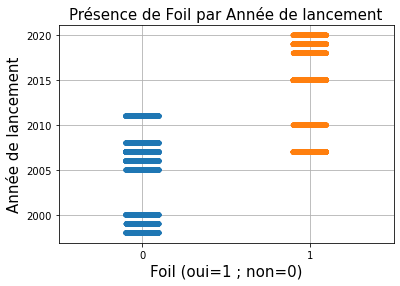

In [21]:
sns.stripplot(data=df, y='Année lancement', x='Foil')

plt.title("Présence de Foil par Année de lancement" , fontsize=LABEL_FONT_SIZE)
plt.grid()
plt.xlabel('Foil (oui=1 ; non=0)', fontsize=LABEL_FONT_SIZE)
plt.ylabel('Année de lancement', fontsize=LABEL_FONT_SIZE);

In [22]:
df.loc[df["Foil"]==1, "Année lancement"].unique()

array([2019, 2010, 2015, 2020, 2007, 2018])

In [23]:
df.loc[df["Dérives"]==3, "Année lancement"].unique()

array([2010, 2019, 2015, 2020, 2007, 2018])

### Vitesses / Classement général

On observe que la vitesse est globalement plus élevées pour les bateaux avec foils tel qu'illustré dans les 2 séries de graphes ci-après.

La série de deux graphes ci-dessous affichent la moyenne de la vitesse des 10 premiers bateaux disposant de foil et des 10 premiers sans foil sur les dernières 24h et en moyenne glissante sur 5 jours.

On remarque que la courbe bleue est sensiblement au-dessus en moyenne et très nettement sur 5 jours glissants.

In [24]:
dfz= df.copy()
dfz = dfz.loc[dfz['Fichier de resultats'].str.endswith("140000")]

[1, 2, 3, 5, 6, 8, 11, 13, 15, 16, 17, 18, 25, 34]
[4, 7, 9, 10, 12, 14, 19, 20, 21, 22, 23, 24, 25, 34]
81


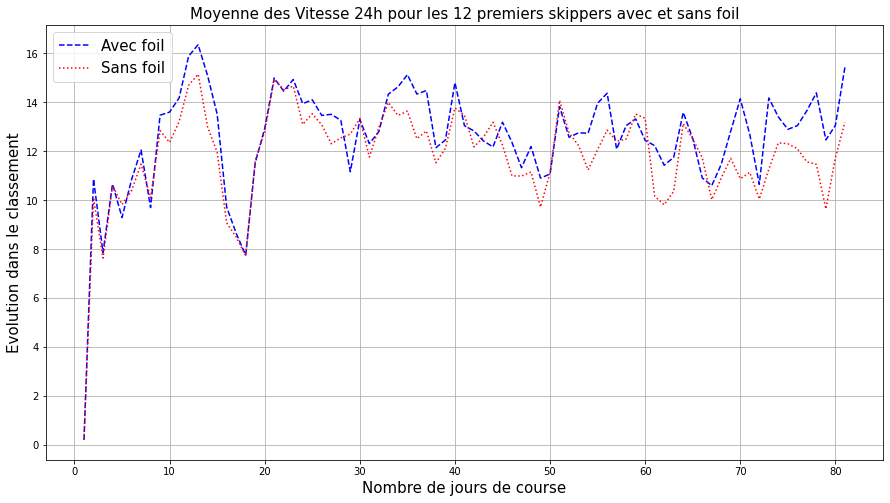

In [25]:
fig = plt.subplots(1, figsize=(15,8))

classes_with_foils = dfz.loc[dfz['Foil']==1 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
classes_without_foils = dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
print(sorted(classes_with_foils))
print(sorted(classes_without_foils))

ROLLING=1
NUM_PREMIER=1
NUM_DERNIER=12
CRITERE='Vitesse 24h'

# WITH FOILS
# for i  in classes_with_foils[1:4]:
#     print(i)
#     skipper = dfz.loc[dfz['Classement final']==i, 'Skipper'].unique().tolist()
sw = dfz.loc[dfz['Classement final'].isin(classes_with_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
sw = sw.groupby('Fichier de resultats').mean()
sw = (sw).rolling(ROLLING).mean()
print(len(sw))
xabs=np.linspace(1, len(sw), len(sw))
plt.plot(xabs, sw, "b--", label="Avec foil")

# WITHOUT FOILS
swo = dfz.loc[dfz['Classement final'].isin(classes_without_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
swo = swo.groupby('Fichier de resultats').mean()
swo = (swo).rolling(ROLLING).mean()
xabs=np.linspace(1, len(swo), len(swo))
plt.plot(xabs, swo, "r:", label="Sans foil")

plt.title("Moyenne des Vitesse 24h pour les 12 premiers skippers avec et sans foil", fontsize=LABEL_FONT_SIZE)
plt.grid()
plt.xlabel('Nombre de jours de course', fontsize=LABEL_FONT_SIZE)
plt.ylabel('Evolution dans le classement', fontsize=LABEL_FONT_SIZE)


plt.legend(fontsize=LABEL_FONT_SIZE);

[1, 2, 3, 5, 6, 8, 11, 13, 15, 16, 17, 18, 25, 34]
[4, 7, 9, 10, 12, 14, 19, 20, 21, 22, 23, 24, 25, 34]
81


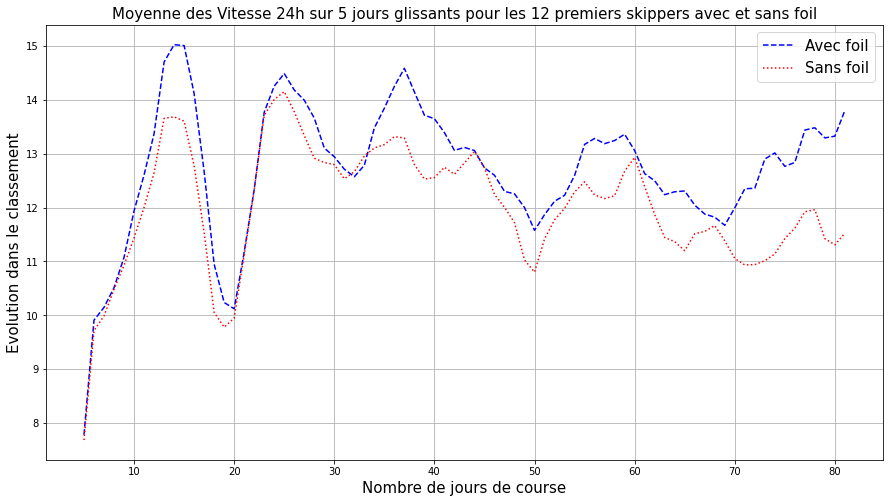

In [26]:
fig = plt.subplots(1, figsize=(15,8))

classes_with_foils = dfz.loc[dfz['Foil']==1 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
classes_without_foils = dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
print(sorted(classes_with_foils))
print(sorted(classes_without_foils))

ROLLING=5
NUM_PREMIER=1
NUM_DERNIER=12
CRITERE='Vitesse 24h'

# WITH FOILS
# for i  in classes_with_foils[1:4]:
#     print(i)
#     skipper = dfz.loc[dfz['Classement final']==i, 'Skipper'].unique().tolist()
sw = dfz.loc[dfz['Classement final'].isin(classes_with_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
sw = sw.groupby('Fichier de resultats').mean()
sw = (sw).rolling(ROLLING).mean()
print(len(sw))
xabs=np.linspace(1, len(sw), len(sw))
plt.plot(xabs, sw, "b--", label="Avec foil")

# WITHOUT FOILS
swo = dfz.loc[dfz['Classement final'].isin(classes_without_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
swo = swo.groupby('Fichier de resultats').mean()
swo = (swo).rolling(ROLLING).mean()
xabs=np.linspace(1, len(swo), len(swo))
plt.plot(xabs, swo, "r:", label="Sans foil")

plt.title("Moyenne des Vitesse 24h sur 5 jours glissants pour les 12 premiers skippers avec et sans foil", fontsize=LABEL_FONT_SIZE)
plt.grid()
plt.xlabel('Nombre de jours de course', fontsize=LABEL_FONT_SIZE)
plt.ylabel('Evolution dans le classement', fontsize=LABEL_FONT_SIZE)
plt.legend(fontsize=LABEL_FONT_SIZE)

Sur ce deuxième graphique on visualise la densité de relevés de VMG par rapport à la position au classement général sur 24h

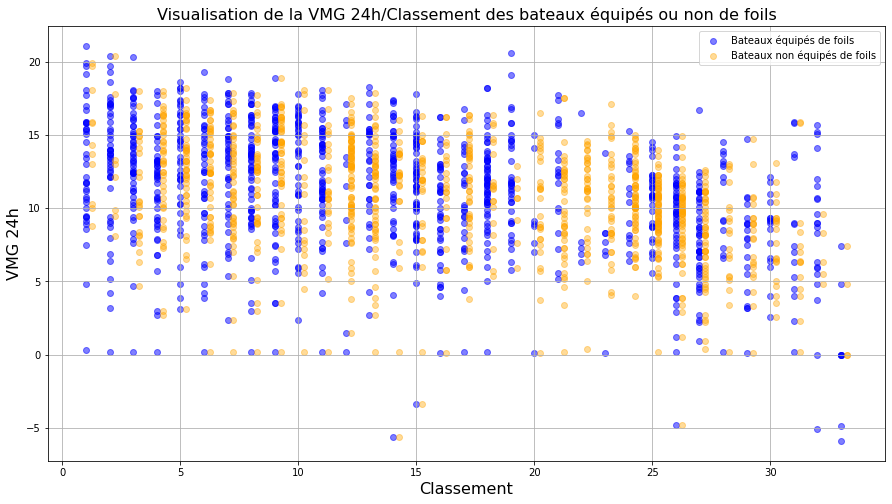

In [27]:
fig = plt.subplots(1, figsize=(15,8))

def compare_foil(num_df, nom_colonne_x, nom_colonne_y):
    classes_with_foils = dfz.loc[dfz['Foil']==1 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
    classes_without_foils = dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
#     print(sorted(classes_with_foils))
#     print(sorted(classes_without_foils))

    NUM_PREMIER=1
    NUM_DERNIER=12
    CRITERE='VMG 24h'
    
    

    ax = plt.subplot(111)
    
    syx = dfz.loc[dfz['Classement final'].isin(classes_with_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Classement']]
    
    dim = len(syx['Classement'])
    w = 0.75
    dimw = w / dim
    
    ax.scatter(syx['Classement'], syx[CRITERE],\
               label="Bateaux équipés de foils", c='blue', marker='o', alpha=0.5)
    
    syx = dfz.loc[dfz['Classement final'].isin(classes_without_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Classement']]
    ax.scatter(syx['Classement'] + 0.25, syx[CRITERE],\
               label="Bateaux non équipés de foils", c='orange', marker='o', alpha=0.4)
    ax.grid()
    ax.legend()
    ax.set_title(f"Visualisation de la {nom_colonne_y}/{nom_colonne_x} des bateaux équipés ou non de foils", fontsize = 16)
    ax.set_xlabel(nom_colonne_x, fontsize = 16)
    ax.set_ylabel(nom_colonne_y, fontsize = 16)
#     fig.tight_layout()
#     ax.set_xticks(34 + 0.25 / 2)
    
    plt.show()

compare_foil(df, "Classement", "VMG 24h")

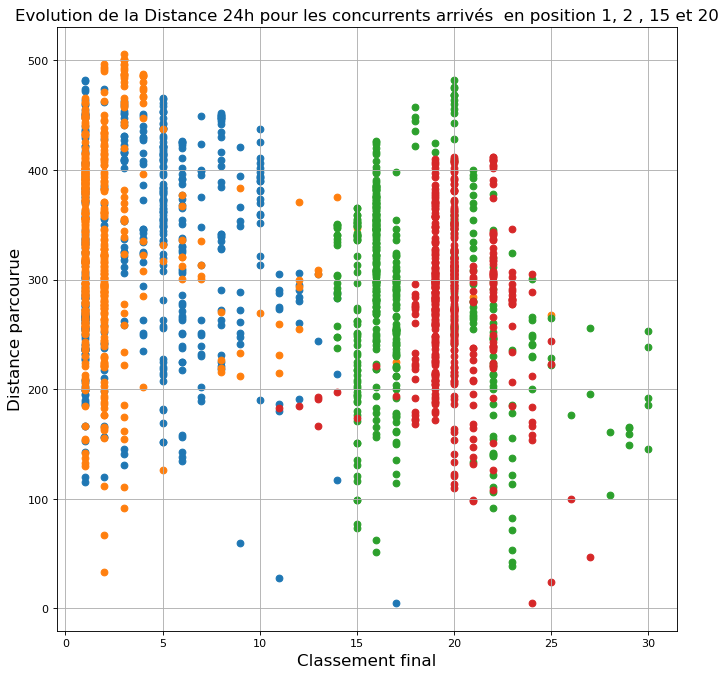

In [28]:
# 
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=80)

for i in [1, 2, 15, 20]:
    s = df.loc[df['Classement final']==i]
    X = s['Classement']
    Y = s['Distance 24h']
    x = np.linspace(0, len(s)/4, len(s))
    ax.scatter(X, Y)
    

plt.title("Evolution de la Distance 24h pour les concurrents arrivés  en position 1, 2 , 15 et 20", fontsize=LABEL_FONT_SIZE)
plt.grid()
plt.xlabel('Classement final', fontsize=LABEL_FONT_SIZE)
plt.ylabel('Distance parcourue', fontsize=LABEL_FONT_SIZE);

On remarque la pente négative de la droite de régression qu'on pourrait tracer sur ces données.

([Retour Sommaire](#Sommaire))

## Timeseries <a class="anchor" id="III">

#### L'évolution du classement général des 5 premiers skippers 

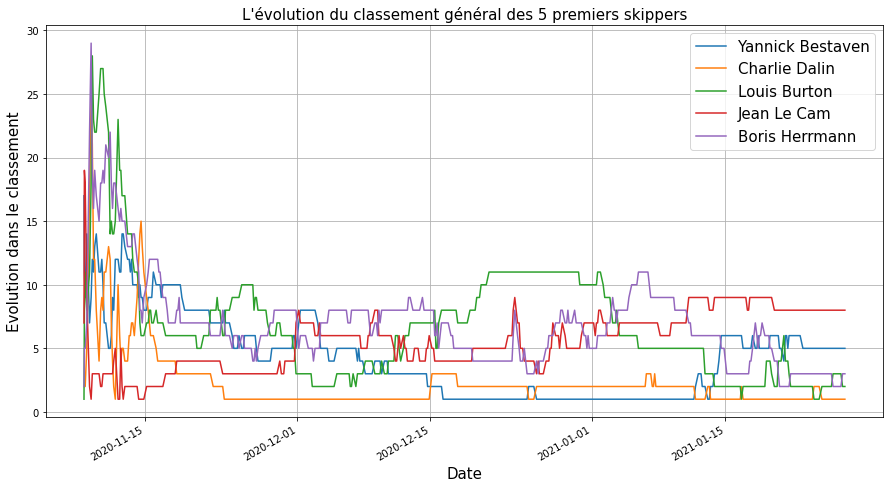

In [29]:
%matplotlib inline

fig = plt.subplots(1, figsize=(15,8))

skippers = get_skippers_ordered(df)

for skipper in skippers[0:5]:
    skip = df.loc[(df['Skipper'] == skipper),"Classement"]
    skip.plot(label = skipper)
plt.title("L'évolution du classement général des 5 premiers skippers", fontsize=LABEL_FONT_SIZE)
plt.grid()
plt.xlabel('Date', fontsize=LABEL_FONT_SIZE)
plt.ylabel('Evolution dans le classement', fontsize=LABEL_FONT_SIZE)
plt.legend(fontsize=LABEL_FONT_SIZE);

#### La vitesse (VMG 24h) sur 7 jours glissants pour les 3 premiers concurrents

On note des décalages de phase très nets pour des configurations de bateaux très similaires. Le décalage et l'amplitude sont certainement dues à des facteurs de vents et décision de routes.

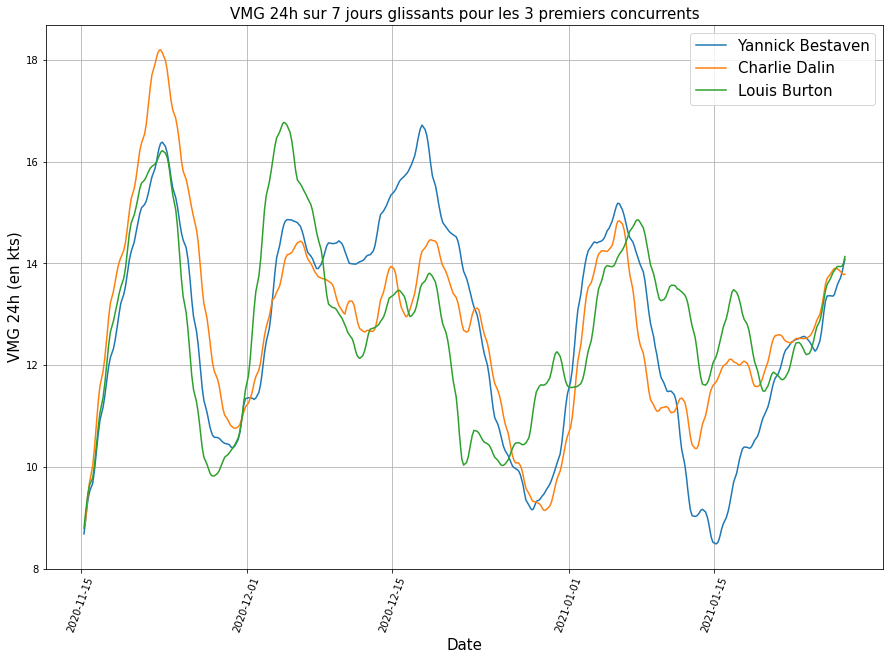

In [30]:
def time_series1(df, skippers):
    CRITERE="VMG 24h"
    df_run = df[['Skipper', CRITERE]] 
    
    plt.figure(2, figsize=(15, 10))
    
    for skipper in skippers:
        df_skipper = df_run.loc[df_run['Skipper'] == skipper, [CRITERE]]
        # 6 x 7 = 6 classements par jour * 7 jours glissants
        plt.plot(df_skipper[CRITERE].rolling(6*7).mean(), label=skipper) 
    
    plt.title("VMG 24h sur 7 jours glissants pour les 3 premiers concurrents", fontsize=LABEL_FONT_SIZE)
    plt.xticks(rotation=70)
    plt.xlabel('Date', fontsize=LABEL_FONT_SIZE)
    plt.ylabel(CRITERE +' (en kts)', fontsize=LABEL_FONT_SIZE)
    plt.grid()

    plt.legend(loc='upper right', fontsize=LABEL_FONT_SIZE)
    plt.plot()
    
skippers = get_skippers_ordered(df)
time_series1(df, skippers[0:3])    

    

In [31]:
# df.loc[df['Classement final']==1, 'Skipper'].unique().tolist()

#### L'évolution du classement général des skippers contraints à l'abandon

Ce graphe affiche les positions au classement des 8 skippers contraint à l'abandon

In [32]:
skippers_abandon = df.loc[df['Classement final']==34, 'Skipper'].unique().tolist()
print(f'Les skippers ayant abandonné {skippers_abandon}')

Les skippers ayant abandonné ['Sébastien Simon', 'Samantha Davies', 'Alex Thomson', 'Fabrice Amedeo', 'Nicolas Troussel', 'Sébastien Destremau', 'Kevin Escoffier', 'Isabelle Joschke']


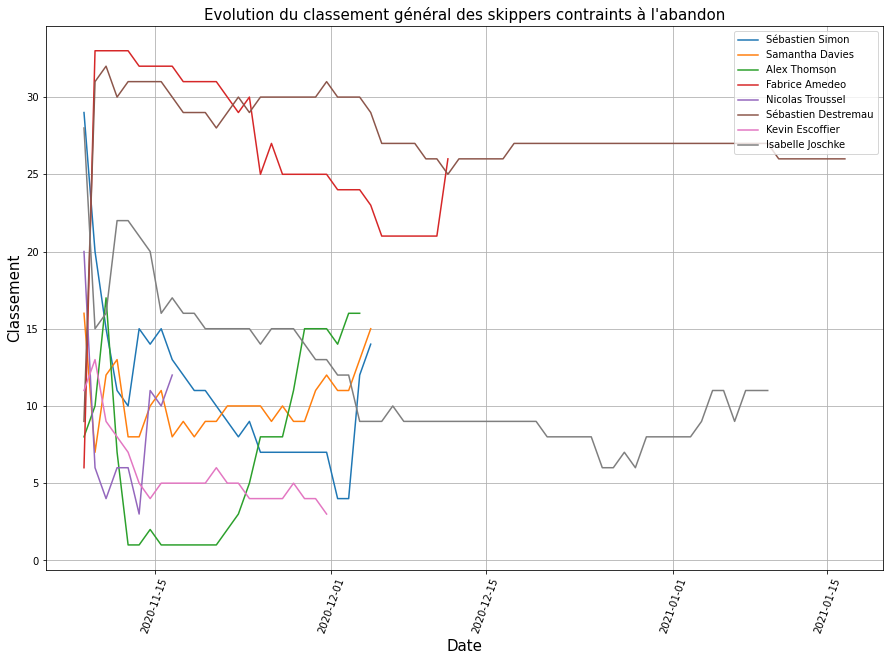

In [33]:

def time_series(df, skippers):
    CRITERE="Classement"
    df_run = df[['Skipper', CRITERE]] 
    
    plt.figure(2, figsize=(15, 10))
    
    for skipper in skippers:
        df_skipper = df_run.loc[df_run['Skipper'] == skipper, [CRITERE]]
        plt.plot( df_skipper[CRITERE], label=skipper) 
    
    plt.title("Evolution du classement général des skippers contraints à l'abandon", fontsize=LABEL_FONT_SIZE)
    plt.xticks(rotation=70)
    plt.xlabel('Date', fontsize=LABEL_FONT_SIZE)
    plt.ylabel(CRITERE, fontsize=LABEL_FONT_SIZE)
    plt.grid()
    plt.legend(loc='upper right')
    plt.plot()
    

time_series(dfz, skippers_abandon)    
    

#### Comparaison des distances aprcourues 

Visualisation de la distance du 1er et des concurrents ayant abandonné.

On voit que certains ont abandonné mais étaient dans la moyenne temps/distances parcourues. Seuls Amadeo et Destremeau ont abandonné avec un gros écart.

In [34]:
skippers_dist = skippers_abandon
skippers_dist.append('Yannick Bestaven')

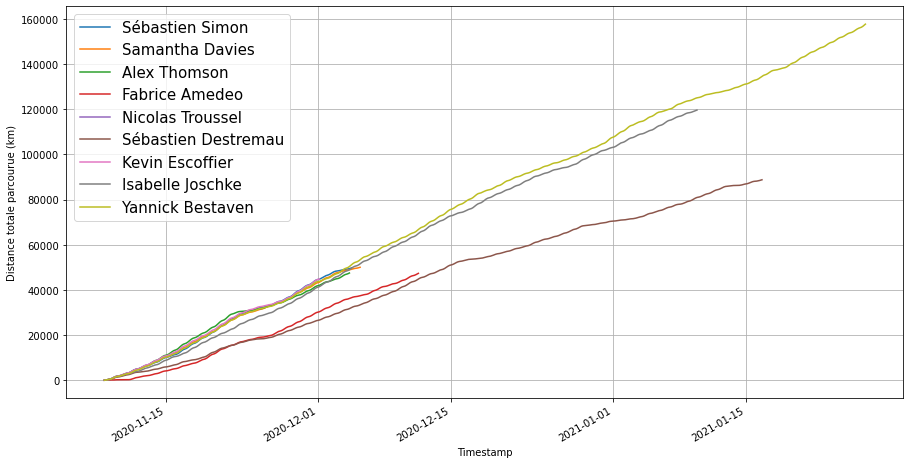

In [35]:
fig = plt.subplots(1, figsize=(15,8))
for skipper in skippers_dist:
    skip = df.loc[(df['Skipper'] == skipper), "Distance 24h"]
    skip.cumsum().plot(label = skipper)

plt.ylabel('Distance totale parcourue (km)')
plt.grid()
plt.legend(fontsize=LABEL_FONT_SIZE);

([Retour Sommaire](#Sommaire))

## Régression linéaire <a class="anchor" id="IV">

Mise en oeuvre d'une régression linéaire entre l'évolution du classement et la VMG 24h


Cela fait ressortir la vitesse moyenne sur 24h en fonction de la position dans la course

On peut voir que logiquement plus la position en basse au classement moins la vitesse est élevée.

Corrélation entre le rang et la vitesse VMG 24h:

* Coefficient : -0.2119
* Intercept : 14.1807
* Score R2 : 0.6592



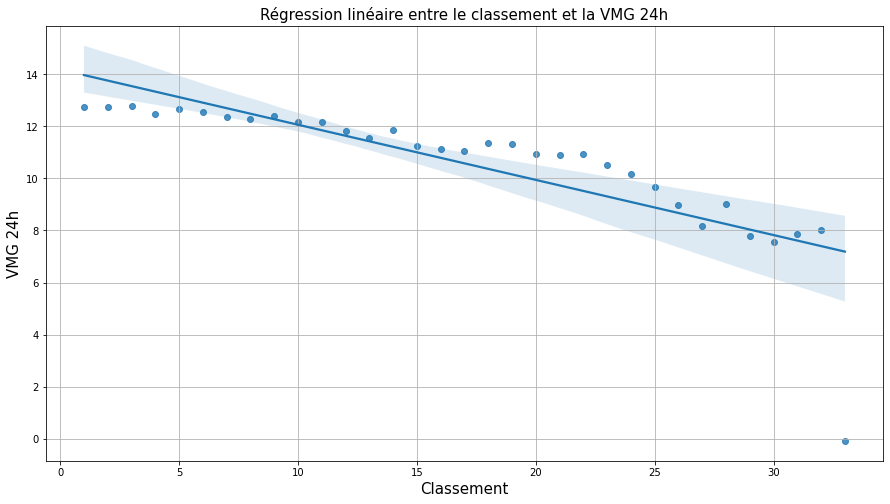

In [36]:
import sklearn
from sklearn.linear_model import LinearRegression

CRITERE_REG="VMG 24h"
df_vmg = pd.DataFrame(df.groupby('Classement')[CRITERE_REG].mean())
position = df_vmg.index.values.reshape(-1,1)
s_vmg = df_vmg[CRITERE_REG]

lr = LinearRegression(fit_intercept=True)
lr.fit(position, s_vmg)
VMG_pred = lr.predict(position)

coef = np.round(lr.coef_[0],4)
intercept = np.round(lr.intercept_,4)
r2 = np.round(sklearn.metrics.r2_score(s_vmg, VMG_pred),4)

print(f"Corrélation entre le rang et la vitesse {CRITERE_REG}:\n\n\
* Coefficient : {coef}\n\
* Intercept : {intercept}\n\
* Score R2 : {r2}\n")

fig = plt.subplots(1, figsize=(15,8))

plt.grid()
plt.title("Régression linéaire entre le classement et la VMG 24h", fontsize=LABEL_FONT_SIZE)
plt.ylabel(CRITERE_REG, fontsize=LABEL_FONT_SIZE)
plt.xlabel("Classement", fontsize=LABEL_FONT_SIZE)
sns.regplot(x = position, y = s_vmg, data = df_vmg);

On remarque que le classement 33 est à zéro. Ce qui est une valeur extrème qui influe sur la courbe. Aussi on établit une deuxième régression sans ce classement qui représente mieux les données de course. 

Le classement doit représenter les bateaux qui ont été en avaries ou à l'arrêt.

Corrélation entre le rang et la vitesse VMG 24h:

* Coefficient : -0.1679
* Intercept : 13.682
* Score R2 : 0.8891



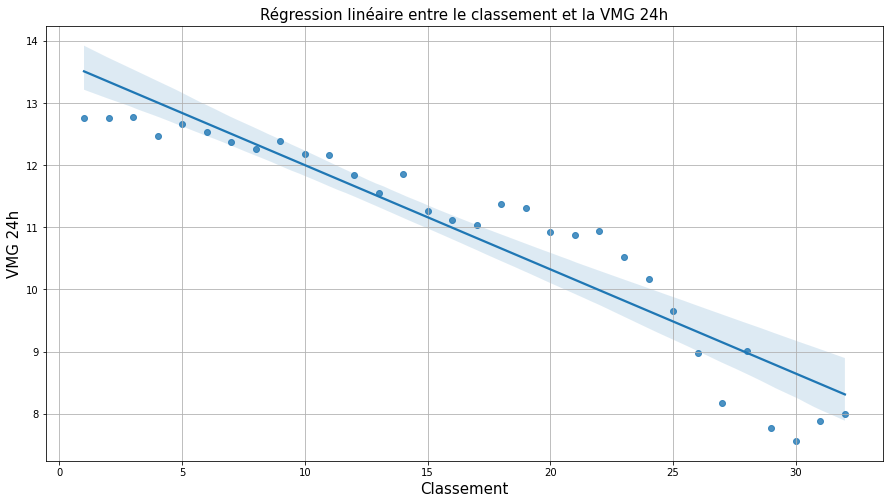

In [37]:
import sklearn
from sklearn.linear_model import LinearRegression

CRITERE_REG="VMG 24h"
dftemp = df.loc[df['Classement']!=33]
df_vmg = pd.DataFrame(dftemp.groupby('Classement')[CRITERE_REG].mean())
position = df_vmg.index.values.reshape(-1,1)
s_vmg = df_vmg[CRITERE_REG]

lr = LinearRegression(fit_intercept=True)
lr.fit(position, s_vmg)
VMG_pred = lr.predict(position)

coef = np.round(lr.coef_[0],4)
intercept = np.round(lr.intercept_,4)
r2 = np.round(sklearn.metrics.r2_score(s_vmg, VMG_pred),4)

print(f"Corrélation entre le rang et la vitesse {CRITERE_REG}:\n\n\
* Coefficient : {coef}\n\
* Intercept : {intercept}\n\
* Score R2 : {r2}\n")

fig = plt.subplots(1, figsize=(15,8))

plt.grid()
plt.title("Régression linéaire entre le classement et la VMG 24h", fontsize=LABEL_FONT_SIZE)
plt.ylabel(CRITERE_REG, fontsize=LABEL_FONT_SIZE)
plt.xlabel("Classement", fontsize=LABEL_FONT_SIZE)
sns.regplot(x = position, y = s_vmg, data = df_vmg);

([Retour Sommaire](#Sommaire))

## PCA <a class="anchor" id="V">

Pour les régressions linéaires et la PCA il nous as semblé utile de crée un dataframe de données numériques uniquement


In [38]:
def df_with_numerical_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    num_df = df.select_dtypes(include=numerics)
    return num_df

num_df = df_with_numerical_columns(df)

Nous étions bien parti pour établir une PCA et déterminer les variables qui ont une influence sur le classement final mais le temps à manqué.

([Retour Sommaire](#Sommaire))

## Cartographie <a class="anchor" id="VI">

Pour visualiser les trajectoires des concureents nous avons établi les cartographie suivantes.

#### Route des 5 gagnants

Dans la première cartographie ci-dessous nous affichons les routes des 5 premiers arrivés.

In [39]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox())
skippers=df.loc[df['Classement final'].isin(range(1,25)), "Skipper"].unique().tolist()

skippers=[]
for k in range(1, 26):
    skip = df.loc[df['Classement final']==k, 'Skipper' ].unique().tolist()
    skippers.append(skip[0])

# print(skippers,order)
for i, skipper in enumerate(skippers[0:5]): 
    dfsk = df.loc[df['Skipper'] == skipper]
    stamp = dfsk.index

    fig.add_trace(go.Scattermapbox(
        visible=True,
        mode = "markers+lines",
        lon = dfsk["Longitude_dec"].round(5),
        lat = dfsk["Latitude_dec"].round(5),
        name = skipper,
        marker = {'size': 3},
                text= stamp ))
    i+=1
     

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        
        'center': {'lon': 0, 'lat': 0},
        'style': "stamen-watercolor",
        'center': {'lon': 0, 'lat': 0},
        'zoom': 0.6})

fig.show()

#### Routes des concurrents contraints à l'abandon

La cartograhie suivante montre les routes interrompues des concurrents contraints à l'abandon.

Un élément intéressant à noter, cette carto permet de visualiser que 6 des 8 concurrents ayant abandonné, y ont été contraints juste avant le Cap de Bonne Espérance dans l'Atlantique Sud. Il s'agissait d'ailleurs de bateaux avec des foils. Le 7ème abandon avec foil est celui de Isabelle Joschke après le passage du Horn, là encore dans l'Atlantique Sud. 100% d'abandon des bateaux ayant un foil a eu lieu dans l'Atlantique Sud. Nous n'irons pas jusqu'à en tirer des conclusions. Peut-être est-ce dû à des conditions météorologiques (voir la partie ouverture dans la [Conclusion](#Conclusion)

Sébastien Destremau qui n'avait pas de foil s'est arrêté en Nouvelle Zélande.


In [40]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox())
skippers=df.loc[df['Classement final'].isin(range(33,35)), "Skipper"].unique().tolist()

print("Liste des skippers ayant dû abandonner :\n", skippers)


# print(skippers,order)
for i, skipper in enumerate(skippers): 
    dfsk = df.loc[df['Skipper'] == skipper]
    stamp = dfsk.index

    fig.add_trace(go.Scattermapbox(
        visible=True,
        mode = "markers+text+lines",
        lon = dfsk["Longitude_dec"].round(5),
        lat = dfsk["Latitude_dec"].round(5),
        name = skipper,
        marker = {'size': 3},
                text= stamp ))
    i+=1
     

fig.update_layout(
    title='Routes des concurrents contraints à l\'abandon',
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        
        'center': {'lon': 0, 'lat': 0},
        'style': "stamen-watercolor",
        'center': {'lon': 0, 'lat': 0},
        'zoom': 0.6})

fig.show();

Liste des skippers ayant dû abandonner :
 ['Sébastien Simon', 'Samantha Davies', 'Alex Thomson', 'Fabrice Amedeo', 'Nicolas Troussel', 'Sébastien Destremau', 'Kevin Escoffier', 'Isabelle Joschke']


In [41]:
print("Dernière position de Isabelle Joschke")
df.loc[df["Skipper"]=="Isabelle Joschke", ["Latitude_dec", "Longitude_dec"]].iloc[-1]

Dernière position de Isabelle Joschke


Latitude_dec    -44.652500
Longitude_dec   -37.125833
Name: 2021-01-09 21:00:00, dtype: float64

In [42]:
print("Sébastien Destremau le seul abandon sans foil")
df.loc[df['Skipper'].isin(['Sébastien Destremau' ]), 'Foil'].unique().tolist()

Sébastien Destremau le seul abandon sans foil


[0]

Correction à apporter sur l'affichage de la carte:
* [fix ligne qui traverse carte](https://community.plotly.com/t/plotly-scattermapbox-positive-to-negative-longitudes/37748/2)    

([Retour Sommaire](#Sommaire))

# Conclusion <a class="anchor" id="Conclusion"> 


Quand on vient de terminer *La Longue Route* de Bernard Moitessier on se rend compte des progrès en matière de navigation.
    
Le sujet du projet est vraiment intéressant. Cela a été un plaisir de travailler sur ces données. Beaucoup de travail de découverte et d'exploration de pandas, des lib graphiques. Nous espérons que cela vous aura plus.

J'ai utilisé le nous par convention.
    
### Ouverture 

Nous avons envisagé d'inclure des données météorologiques. Il arurait été intérressant de corréler les classements avec des informations de directions des vents, de houle et de déterminer les routes optimales en fonction des conditions de vents, dépressions ou anticyclones.
    
Cela aurait pu expliquer les phénomènes de casse des bateaux avec foils notamment au sortir de l'Atlantique avant le cap de Bonne Espérance.
    
Les données de la Nasa sont une bonne source d'information. Nous y avons trouvé des informations sur la directions des vents chaque heure en fonction des coordonnées.
    
Les points d'entrée de data météorologiques ci-dessous correspondant au dernier enregistrement de position de Isabelle Joschke 	(Date Abandon : 2021-01-09 21:23:00):
* [JSON - LARC NASA - Vents](https://power.larc.nasa.gov/api/temporal/hourly/point?parameters=T2M&community=AG&longitude=-37.125833&latitude=-44.652500&start=20210901&end=20210901&format=json&wind-surface=SeaIce&wind-elevation=50)   
* [JSON - LARC NASA - Vents, direction, vitesse, pression, température](https://power.larc.nasa.gov/api/temporal/hourly/point?parameters=WS10M,WD10M,T2MDEW,T2MWET,T2M,V10M,RH2M,PS,PRECTOT,QV2M,U10M&community=SB&longitude=-37.125833&latitude=-44.652500&start=20210901&end=20210901&format=JSON)

Il serait facile d'obtenir pour chaque concurrent les détails à chaque coordonnées enregistrées.

    